In [1]:
import os
import sys
import imageio
import numpy as np
import skimage
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt

from pydmd import MrDMD, DMD

In [2]:
DATASET = os.path.join(os.curdir, "../data")
os.listdir(DATASET)

['skating',
 'office',
 'peopleInShade',
 'copyMachine',
 'PETS2006',
 'pedestrians',
 'backdoor',
 'cubicle',
 'busStation',
 'sofa']

In [3]:
def load_images(path, shape=None):
    files = os.listdir(path)
    data = None

    for f in files:
        fp = os.path.join(path, f)
        num = int(f[2:8])
        im = io.imread(fp, as_gray=True)
        if shape is not None:
            im = transform.resize(im, shape)
        if data is None:
            data = np.zeros((im.size, len(files)))
        elif num < data.shape[1]:
            data[:,num] = im.flatten()
            
    return data

In [4]:
# Investigate a single video: Pedestrians
# Was having memory problems, so controlled the image size with shape
# shape = (60,90);
shape = (120,180)
dt = 1  # Assumption
PEDESTRIANS = os.path.join(DATASET,'pedestrians/input')
ims = load_images(PEDESTRIANS, shape)


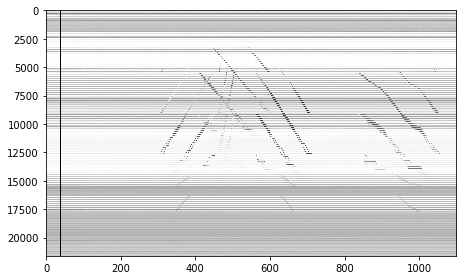

In [426]:
# This is what the data matrix looks like. Note that its very easy to pick out the pixels where 
# pedestrians are walking. However, they are pretty scattered and non-local. It would be interesting
# to try the tensor-based decomposition instead.

def plot_data(data):
    fig = io.imshow(np.real(data))
    fig.axes.set_aspect('auto')
    
def plot_image(im, shape=shape):
    io.imshow(im.clip(min=0,max=1).reshape(shape), vmin=0, vmax=1, cmap="gray")
    
plot_data(ims)


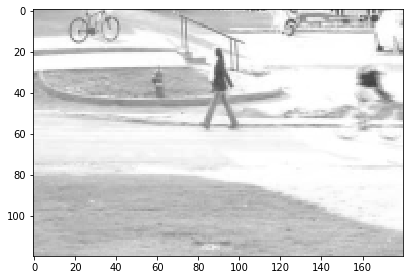

In [427]:
# Plot a single image
plot_image(ims[:,500].reshape(shape))

In [7]:
# Inverting the images this way seems to give the best results. TODO: Why?
data = 1-ims
data.min(), data.max(), data.mean()

(0.0, 1.0, 0.15394501515996645)

In [8]:
# Running the algorithm on the orignal images doesn't seem to work, perhaps because the images are so uniform (mostly 1s)?
# setting svd_rank=0 makes pyDMD compute the optimal rank itself. Since we're doing background subtraction, we only really 
# care about keeping one mode: the background.
dmd = DMD(svd_rank=1)
dmd.fit(X=data)

/home/haakonrr/anaconda3/envs/research/lib/python3.7/site-packages/pydmd/dmdbase.py:215: UserWarning: Input data matrix X has condition number 1638755846755606.0. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


In [9]:
# Rescale the data back to the original range
reconstructed = 1-dmd.reconstructed_data.real
reconstructed = np.interp(reconstructed, (reconstructed.min(), reconstructed.max()), (0,1))

(0.0, 1.0, 0.9889784025465304, 956.6093873394304)

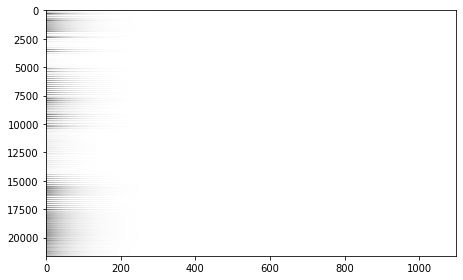

In [10]:
# Plot the reconstructed data. With only rank one, the reconstruction is useless because the mode decays. But this isn't really 
# important, because we will just use the fist reconstructed snapshot as the background.
plot_data(reconstructed)
reconstructed.min(), reconstructed.max(), reconstructed.mean(), np.linalg.norm(ims - reconstructed)

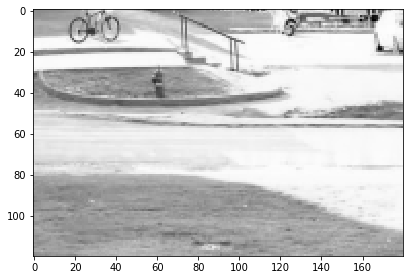

In [11]:
# Plot the first image, should just be the background
plot_image(reconstructed[:,0].reshape(shape))

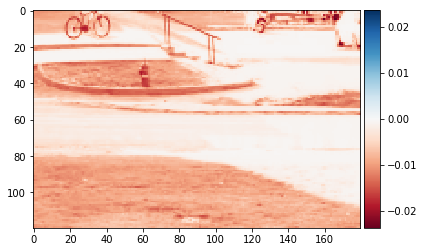

In [13]:
plot_image(dmd.modes[:,0].real.reshape(shape))

In [369]:
# Start 
i = 500

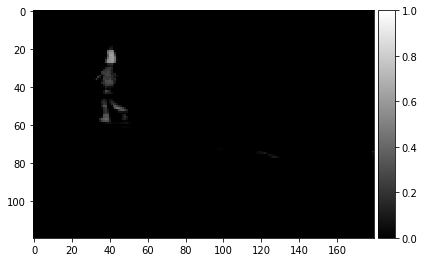

In [422]:
# Keep evaluating this cell with ctrl-enter to see a slideshow
background = reconstructed[:,0].reshape(shape)
io.imshow((background - ims[:,i].reshape(shape)).clip(min=0,max=1), vmin=0, vmax=1, cmap="gray")
i += 1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])